
# DCGANs - Deep Convolutional Generative Adverserial Networks
+ Research Paper for DCGANs https://arxiv.org/abs/1511.06434

+ [Data](#data)
+ [Reshape and Rescale Images for DCGAN](#reshapeandscale)
+ [Filtering out the Data for Faster Training on Smaller Dataset](#filter)
+ [Build GAN](#buildingGAN)
    + [Discriminator](#discriminator)
    + [Generator](#generator)
    + [Combining Generator and Discriminator as GAN and compile](#gancombination)
+ [Setting up Training Batches](#trainingbatches)
    + [Discriminator Training Phase (Phase 1)](#phase1)
    + [Generator Training Phase (Phase 2)](#phase2)
+ [Training GAN Loop](#trainingGAN)
+ [Generating Images after training](#generatingaftertraining)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# <a name=data>Data</a>

In [63]:
from tensorflow.keras.datasets import mnist

In [64]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [65]:
X_train.shape

(60000, 28, 28)

In [66]:
y_train.shape

(60000,)

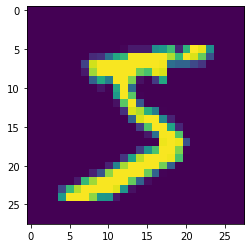

In [67]:
plt.imshow(X_train[0]);

-------

# <a name=reshapeandscale>Reshape and Rescale Images for DCGAN</a>

Generator will use **tanh activation function (hyperbolic activation function)** for the last layer, so we want to **reshape X_train to be within -1 to 1 limits**.

In [68]:
X_train = X_train/255

Mulitplying with 2 will result in 0 to 2 data points. Then subtracting 1 will result in -1 to 1 limits.

In [69]:
X_train = X_train.reshape(-1,28,28,1) * 2.0 -1

In [70]:
X_train.min(), X_train.max()

(-1.0, 1.0)

----

# <a name=filter>Filtering out the Data for Faster Training on Smaller Dataset</a>

In [71]:
only_zeros = X_train[y_train == 0]

In [72]:
only_zeros.shape

(5923, 28, 28, 1)

# <a name=buildingGAN>Build GAN</a>

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose

In [74]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

# <a name=generator>Generator</a>

In [75]:
generator = Sequential()

generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))

generator.add(Reshape([7,7,128]))

generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))

generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

# <a name=discriminator>Discriminator</a>

In [76]:
discriminator = Sequential()

# one convolutional layer with dropout
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same', 
                                         activation=LeakyReLU(0.3),
                                         input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))

# one convolutional layer with dropout
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same', 
                                         activation=LeakyReLU(0.3),
                                         input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))

# Flatten
discriminator.add(Flatten())

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

In [77]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# <a name=gancombination>Combining Generator and Discriminator as GAN and compile</a>

In [78]:
GAN = Sequential([generator, discriminator])

In [79]:
discriminator.trainable = False

In [80]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')

In [81]:
GAN.layers

In [82]:
GAN.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [83]:
GAN.layers[0].summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
______________________________________________

In [84]:
GAN.layers[1].summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 0
Non-trainable params: 212,865
________________________________________________

------

# <a name=trainingbatches>Setting up Training Batches</a>


In [85]:
import tensorflow as tf

In [86]:
batch_size = 32

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

The buffer_size in Dataset.shuffle() can affect the randomness of your dataset, and hence the order in which elements are produced. 

In [87]:
my_data = only_zeros

### Shuffle Data

In [88]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [89]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

### Batchify

In [90]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

------

# <a name=trainingGAN>Training GAN Loop</a>

**NOTE: The generator never actually sees any real images. It learns by viewing the gradients going back through the discriminator. The better the discrimnator gets through training, the more information the discriminator contains in its gradients, which means the generator can being to make progress in learning how to generate fake images, in our case, fake zeros.**

In [91]:
epochs = 20

In [92]:
# Grab the seprate components
generator, discriminator = GAN.layers

# for every epochs
for epoch in range(epochs):
    print(f'Currently on {epoch+1}')
    
    i =0
    # for every batch in dataset
    for X_batch in dataset:
        i = i + 1
        
        if i % 10 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
            
        #################################################
        ########      TRAINING THE DISCRIMINATOR     ########
        #################################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concat Generated Images vs Real image
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)#concat on rows
        
        # Labels targets set 0 for fake, 1 for real image
        y1 = tf.constant([[0.0]] * batch_size + [[1.1]] * batch_size)
        
        # enable discriminator training
        discriminator.trainable = True
        
        # train the discriminator on this current batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #################################################
        ########      TRAINING THE GENERATOR           ########
        #################################################
        
        # create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
       # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.0]] * batch_size)
        
        # disable discriminator training
        discriminator.trainable = False
        
        # Train the whole GAN model
        GAN.train_on_batch(noise, y2)

print("TRAINING COMPLETE")   

Currently on 1
	Currently on batch number 10 of 185
	Currently on batch number 20 of 185
	Currently on batch number 30 of 185
	Currently on batch number 40 of 185
	Currently on batch number 50 of 185
	Currently on batch number 60 of 185
	Currently on batch number 70 of 185
	Currently on batch number 80 of 185
	Currently on batch number 90 of 185
	Currently on batch number 100 of 185
	Currently on batch number 110 of 185
	Currently on batch number 120 of 185
	Currently on batch number 130 of 185
	Currently on batch number 140 of 185
	Currently on batch number 150 of 185
	Currently on batch number 160 of 185
	Currently on batch number 170 of 185
	Currently on batch number 180 of 185
Currently on 2
	Currently on batch number 10 of 185
	Currently on batch number 20 of 185
	Currently on batch number 30 of 185
	Currently on batch number 40 of 185
	Currently on batch number 50 of 185
	Currently on batch number 60 of 185
	Currently on batch number 70 of 185
	Currently on batch number 80 of 185

	Currently on batch number 170 of 185
	Currently on batch number 180 of 185
Currently on 13
	Currently on batch number 10 of 185
	Currently on batch number 20 of 185
	Currently on batch number 30 of 185
	Currently on batch number 40 of 185
	Currently on batch number 50 of 185
	Currently on batch number 60 of 185
	Currently on batch number 70 of 185
	Currently on batch number 80 of 185
	Currently on batch number 90 of 185
	Currently on batch number 100 of 185
	Currently on batch number 110 of 185
	Currently on batch number 120 of 185
	Currently on batch number 130 of 185
	Currently on batch number 140 of 185
	Currently on batch number 150 of 185
	Currently on batch number 160 of 185
	Currently on batch number 170 of 185
	Currently on batch number 180 of 185
Currently on 14
	Currently on batch number 10 of 185
	Currently on batch number 20 of 185
	Currently on batch number 30 of 185
	Currently on batch number 40 of 185
	Currently on batch number 50 of 185
	Currently on batch number 60 of

# <a name=generatingaftertraining>Generating Images after training</a>

In [96]:
noise = tf.random.normal(shape=[10, codings_size]) #give me 10 images

In [97]:
noise.shape

TensorShape([10, 100])

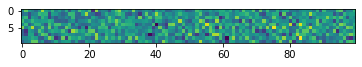

In [98]:
plt.imshow(noise);

In [99]:
# generate the image
images = generator(noise)

In [102]:
singel_image = images[0]

singel_image.shape

TensorShape([28, 28, 1])

In [105]:
singel_image.numpy().reshape(28,28)

array([[-0.974359  , -0.9932678 , -0.99893194, -0.99864864, -0.99864876,
        -0.9984043 , -0.99916595, -0.9976814 , -0.9986732 , -0.99673575,
        -0.99905205, -0.9980102 , -0.9975572 , -0.9957586 , -0.99905366,
        -0.99945605, -0.9991975 , -0.99850297, -0.99903655, -0.9983346 ,
        -0.99865425, -0.9978762 , -0.9995493 , -0.99970055, -0.99914837,
        -0.9979758 , -0.9993717 , -0.99716604],
       [-0.99705184, -0.9987626 , -0.99986875, -0.99996847, -0.9998858 ,
        -0.99987435, -0.9997871 , -0.99985206, -0.99967647, -0.9999016 ,
        -0.999858  , -0.9998806 , -0.9996746 , -0.9999522 , -0.9999905 ,
        -0.9999696 , -0.9999552 , -0.9999278 , -0.9994408 , -0.99986315,
        -0.9995476 , -0.9998553 , -0.9999565 , -0.9999551 , -0.99987614,
        -0.99989545, -0.99986863, -0.998733  ],
       [-0.9956725 , -0.99959856, -0.99998164, -0.99995667, -0.9998473 ,
        -0.9998073 , -0.9999186 , -0.9996258 , -0.9996422 , -0.9997616 ,
        -0.9999744 , -0.9997

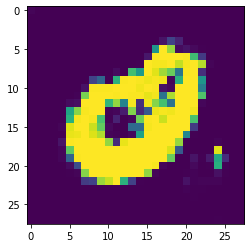

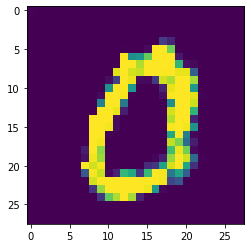

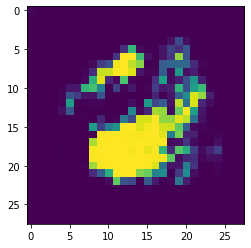

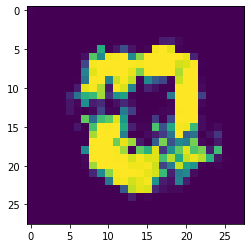

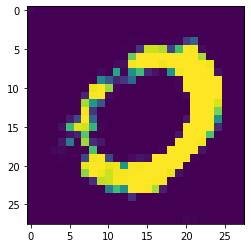

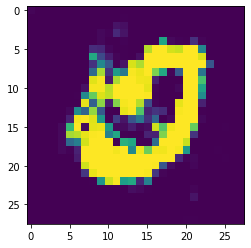

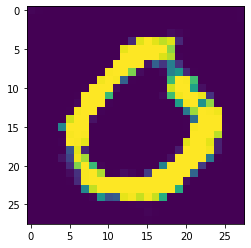

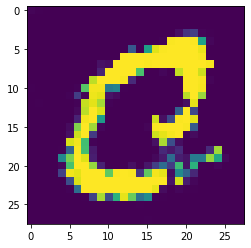

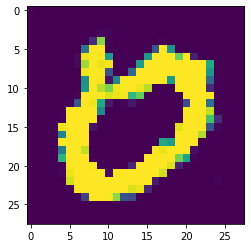

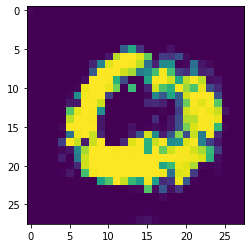

In [106]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()

We can see this improves a lot from GAN using Dense Layers. There are several shapes of zeros unlike in GAN with Dense layers.